In [2]:
import os

## MAIN CONFIGURATIONS
model_id = '1'  # We will train multiple models with the same settings. Keep it as a string!
num_epochs = 10  # Number of epochs the model will train for
batch_size = 32
dataset_percentage = 0.01 # Which percentage of the dataset to use. 0.03 means 4.6k images in the training
init_lr = 1e-4 # Initial Learning Rate
data_augmentation_type = 'none'    # Which data augmentation tecnique are we using?
                                    # 'none' :     only image resize
                                    # 'noaug':     basic geometric transforms
                                    # 'fourier':   fourier transforms

## WHAT WILL THIS SESSION DO?
test_only = False # When True it doesn't train the model, but it just tests an existing one
train_again = False # Trains the model again for num_epoch times
do_model_test = False # Tests the model after training
create_log_file = True
plot_data = True # Plot training data of '{model_filepath}/model.tar'
print_images_during_training = False


model_filepath = f"model_{data_augmentation_type}_id{model_id}"
model_filepath = os.path.join("models", model_filepath)
print(f"{model_filepath = }")

# !tree # Prints folder structure
os.makedirs(model_filepath, exist_ok=True)

model_filepath = 'models/model_none_id1'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import rotate
import numpy as np

In [4]:
!pip install torchmetrics
!pip install torchmetrics[detection]

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.5 MB/s eta 0:00:00a 0:00:01


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"{device = }")

device = device(type='cpu')


In [6]:
import logging
from datetime import datetime

if create_log_file:
    log_filepath = ""
    logger = logging.getLogger('RootLogger')
    log_filepath = os.path.join(model_filepath, f"log" + ".txt")
    print(f"{log_filepath = }")
    
    logging.basicConfig(filename=log_filepath,
                        filemode='a',
                        format='%(asctime)s %(levelname)s %(message)s',
                        level=logging.INFO,
                        datefmt='%m-%d %H:%M:%S',
                        force=True)
else:
    logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                        level=logging.INFO,
                        datefmt='%m-%d %H:%M:%S',
                        force=True)

if log_filepath:
    print(log_filepath)
else:
    print("No logging")

log_filepath = 'models/model_none_id1/log.txt'
models/model_none_id1/log.txt


In [7]:
# FOURIER DATA AUGMENTATION

import torch.fft as fft
import torchvision
import random

from torch import sin, cos

class FourierRandomNoise(object):
        
    def __call__(self, *sample ):
        image = sample[0]

        # Fourier Transform
        fourier = fft.rfftn(image)
        magnitude, angle = self.__polar_form(fourier)

        # Apply Noise in the Frequency Domain
        noise = torch.rand(fourier.size())
        noised_magnitude = torch.mul(magnitude,noise)

        # Inverse Fourier Transform
        fourier = self.__complex_form(noised_magnitude,angle)
        modified_image = fft.irfftn(fourier).byte()
        
        if len(sample) >= 2:
            label = sample[1]
            return modified_image, label

        return modified_image
    
    def __polar_form(self, complex_tensor):
        return complex_tensor.abs(), complex_tensor.angle()

    def __complex_form(self, magnitude, angle):
        return torch.polar(magnitude,angle)
    

class PatchGaussian(object):
    
    def __call__(self,*sample, patch_size=30, sigma_max=0.2):
        '''
        Applies a Gaussian Patch of size patch_size x patch_size to the image.
        The noise of the patch can be modified by specifying its variance
        '''
        
        image = sample[0]
        size = image.size()
        # Scale the image in range [0,1)
        min_val = 0
        max_val = 255
        image = (image-min_val)/(max_val-min_val)

        # Define Gaussian patch
        patch = torch.empty(size).normal_(0,sigma_max)
        # Sample Corner Indices
        ci = random.sample([i for i in range(size[1]-patch_size)],1)[0]
        cj = random.sample([i for i in range(size[2]-patch_size)],1)[0]
        u, v = torch.meshgrid(torch.arange(size[1]), torch.arange(size[2]),indexing='ij')
        u = torch.stack([u,u,u])
        v = torch.stack([v,v,v])
        mask = ((u<ci+patch_size)*(u>ci)*(v<cj+patch_size)*(v>cj)).int()
        patch = mask*patch
        
        if len(sample) >= 2:
            label = sample[1]
            return torch.clip(image+patch,0,1), label
        
        return torch.clip(image+patch,0,1)

class FourierBasisAugmentation(object):
    
    def __call__(self,*sample, l=0.3):
        '''
        Adds a Fourier Basis Function to the image
        '''
        image = sample[0]
        shape = image.size()
        min_val = 0
        max_val = 255
        # Scale the image in range [0,1)
        image = (image-min_val)/(max_val-min_val)

        # Generate a frequency per channel, in the range [0, M], drawn uniformly,
        # where M is the size of the image
        f = (shape[1]-1)*torch.rand(3)
        # Generate a omega per channel, in the range [0, pi], drawn uniformly,
        w = (torch.pi-0)*torch.rand(3)

        # Sample the decay parameter from a l-exponential distribution
        sigma = torch.distributions.Exponential(1/l).sample((3,))

        # Generate basis function
        u, v = torch.meshgrid(torch.arange(shape[1]), torch.arange(shape[2]),indexing='ij')
        basis_r = sigma[0]*sin(2*torch.pi*f[0]*(u*cos(w[0])+v*sin(w[0])-torch.pi/4))
        basis_g = sigma[1]*sin(2*torch.pi*f[1]*(u*cos(w[1])+v*sin(w[1])-torch.pi/4))
        basis_b = sigma[2]*sin(2*torch.pi*f[2]*(u*cos(w[2])+v*sin(w[2])-torch.pi/4))
        noise = torch.stack([basis_r,basis_g,basis_b])

        # Modify The Image
        modified_image = image+noise
        
        if len(sample) >= 2:
            label = sample[1]
            return torch.clip(modified_image,0,1), label

        return torch.clip(modified_image,0,1)

print("ok")

ok


In [38]:
# TRANSFORMATIONS

from torchvision.transforms import v2

img_dimensions = 224

match data_augmentation_type:
    
    case 'noaug':
        
        img_train_transforms = v2.Compose([
             v2.RandomRotation(50),
             v2.RandomAffine(degrees = 0, translate = (0.2, 0.2)),
             v2.RandomHorizontalFlip(p=0.5),
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
             #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
            ])

        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
             #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
            ])

        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
             #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
            ])
    
    case 'fourier':
        
        img_train_transforms = v2.Compose([
             FourierRandomNoise(),
             PatchGaussian(),
             FourierBasisAugmentation(),
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
            ])

        img_validation_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
             #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
            ])

        img_test_transforms = v2.Compose([
            v2.Resize((img_dimensions, img_dimensions)),
             v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
             #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
            ])
    
    case 'none':
        img_train_transforms = v2.Compose([
                v2.Resize((img_dimensions, img_dimensions)),
                v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            ])
        img_validation_transforms = v2.Compose([
                v2.Resize((img_dimensions, img_dimensions)),
                v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            ])
        img_test_transforms = v2.Compose([
                v2.Resize((img_dimensions, img_dimensions)),
                v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            ])

print('ok')

ok


In [34]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def rl_decode(rl_str, height, length):
  mask = np.zeros(shape=(1,height,length))
  couples = rl_str.split()
  for i in range(0, len(couples)-1, 2):
    # print(i)
    el = int(couples[i])
    qty = int(couples[i+1])
    r,c = np.unravel_index(el,(height,length))
    for j in range(qty):
      mask[0, c+j-1, r-1] = 1

    # print(torch.Tensor(mask))
  return torch.Tensor(mask).reshape((768, 768)).gt(0)

def show(imgs, rotation=None):

    if rotation:
          imgs = rotate(imgs, rotation)

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class ShipsDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, targets, transforms = None, target_transforms = None):
        self.file_list = sorted(file_list, key = lambda f: f.split('/')[-1])
        self.targets = sorted(targets, key=lambda d: d['image_id'])
#         self.file_list = file_list
#         self.targets = targets
        self.transform = transforms

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        image = read_image(self.file_list[idx])    # numpy tensor
        image = F.convert_image_dtype(image)
        
      #  print(self.file_list[idx])
      #  print(self.targets[idx])
        
        # Added this line to fix this problem (ENF) during training
        # TypeError: Expected input images to be of floating type (in range [0, 1]), but found type torch.uint8 instead

        try:
            label = self.targets[idx]       # dictionary {"boxes": , "label": }
            label['boxes'] = torch.Tensor(label['boxes'])
            label['labels'] = torch.Tensor(label['labels']).to(dtype=torch.int64).reshape((-1,))
        except IndexError as e:
            Warning(f'Errore con {idx = }')
            plt.imshow(image.permute(1, 2, 0))
            plt.show()

        if self.transform:
            image, label = self.transform(image, label)

        return image, label

print('ok')

ok


In [10]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def rl_decode(rl_str, height, length):
  mask = np.zeros(shape=(1,height,length))
  couples = rl_str.split()
  for i in range(0, len(couples)-1, 2):
    # print(i)
    el = int(couples[i])
    qty = int(couples[i+1])
    r,c = np.unravel_index(el,(height,length))
    for j in range(qty):
      mask[0, c+j-1, r-1] = 1

    # print(torch.Tensor(mask))
  return torch.Tensor(mask).reshape((768, 768)).gt(0)

def show(imgs, rotation=None):

    if rotation:
          imgs = rotate(imgs, rotation)

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class NewShipsDataset(torch.utils.data.Dataset):
    def __init__(self, targets, transforms = None, target_transforms = None):
        self.targets = sorted(targets, key=lambda d: d['image_id'])
#         self.file_list = file_list
#         self.targets = targets
        self.transform = transforms

    def __len__(self, image_id):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        image = read_image(self.file_list[idx])    # numpy tensor
        image = F.convert_image_dtype(image)
        
        print(self.targets[idx]["image_id"])
        
        # Added this line to fix this problem (ENF) during training
        # TypeError: Expected input images to be of floating type (in range [0, 1]), but found type torch.uint8 instead

        try:
            label = self.targets[idx]       # dictionary {"boxes": , "label": }
            label['boxes'] = torch.Tensor(label['boxes'])
            label['labels'] = torch.Tensor(label['labels']).to(dtype=torch.int64).reshape((-1,))
        except IndexError as e:
            Warning(f'Errore con {idx = }')
            plt.imshow(image.permute(1, 2, 0))
            plt.show()

        if self.transform:
            image, label = self.transform(image, label)

        return image, label

print('ok')

ok


In [35]:
if not test_only:

    from sklearn.model_selection import train_test_split
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
    from torchvision import tv_tensors
    from torch.utils.data import SubsetRandomSampler

    # DATASET_DIR = os.path.join(".")
    TRAIN_DIR = "/kaggle/input/airbus-ship-detection/train_v2"
    TEST_DIR = "/kaggle/input/airbus-ship-detection/test_v2"
    # print(DATASET_DIR, TRAIN_DIR, TEST_DIR)

    data_list = glob.glob(os.path.join(TRAIN_DIR,'*.jpg'))
#     train_list, test_list = train_test_split(train_list, test_size = float(1 - dataset_percentage)) # check first cell
#     train_list, val_list = train_test_split(train_list, test_size = 0.2)
#     test_list, _ = train_test_split(test_list, test_size = 0.99)
#     test_list, _ = train_test_split(test_list, test_size = 0.5)
    
   # train_data = ShipsDataset(train_list, transforms = img_train_transforms, targets=np.load('/kaggle/input/targets-rcnn/rcnn_targets_modified.npy', allow_pickle='TRUE'))
    ship_dataset = ShipsDataset(data_list, transforms = img_train_transforms, targets=np.load('/kaggle/input/targets-rcnn/rcnn_targets_modified.npy', allow_pickle='TRUE'))
#     test_data = ShipsDataset(test_list, transforms = img_test_transforms, targets=np.load('/kaggle/input/rcnn-dataset-py/rcnn_targets.npy', allow_pickle='TRUE'))
#     val_data = ShipsDataset(val_list, transforms = img_validation_transforms,targets=np.load('/kaggle/input/rcnn-dataset-py/rcnn_targets.npy', allow_pickle='TRUE') )

    def custom_collate_fn(batch):
        # Why custom_collate_fn? Previously, collate_fn when creating a loader was `lambda x: x`
        # Pickle doesn't pickle function objects. It expects to find the function object by importing its module and looking up its name.
        # Lambdas are anonymous functions (no name) so that doesn't work. The solution is to name the function at module level.

        return batch

    # Fix the generator for reproducibility, remove once we understand that it works
   # generator = torch.Generator().manual_seed(42)
    # Split the dataset into train and test
 #   train_dataset, test_dataset = torch.utils.data.random_split(ship_dataset, [0.7, 0.3], generator)
#    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
 #   test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)
#     val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)
#     test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)
     
    dataset_size = 192_556
    indices = list(range(0, dataset_size))
    np.random.shuffle(indices)
    val_split_index = int(np.floor(0.2 * dataset_size))
    
    train_idx, val_idx = indices[val_split_index:], indices[:val_split_index]

    train_sampler = SubsetRandomSampler(train_idx)
    train_loader = torch.utils.data.DataLoader(dataset = ship_dataset, batch_size = batch_size, shuffle = False, sampler = train_sampler, collate_fn=custom_collate_fn)
    
    val_sampler = SubsetRandomSampler(train_idx)
    val_loader = torch.utils.data.DataLoader(dataset = ship_dataset, batch_size = batch_size, shuffle = False, sampler = val_sampler, collate_fn=custom_collate_fn)

     
    print(len(train_loader))
    print(len(val_loader))
#     print(len(test_loader))

    # https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
    # La documentazione non è chiara sulla posizione dei punti per le ground-truth!
    # /Users/ludovicamazzucco/Library/Python/3.9/lib/python/site-packages/torchvision/models/detection/generalized_rcnn.py"

print('ok')

4814
4814
ok


In [ ]:
# if not test_only:
    # Save loaders
#     torch.save(train_loader, os.path.join(model_filepath, 'train_loader.pt'))
#     torch.save(val_loader, os.path.join(model_filepath, 'val_loader.pt'))
#     torch.save(test_loader, os.path.join(model_filepath, 'test_loader.pt'))

#     print('Dataset Loaders saved succesfully!')

In [32]:

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset  
    print("computing mean and std of this dataset split...")
    nimages = 0
    mean = 0.
    var = 0.
    for i, batch in enumerate(loader):
        inputs = []
        for el in batch:      
            inputs.append(el[0])
        batch = torch.stack(inputs, dim=0)
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and var
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)
        
    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    print("Done")
    
    return mean, std

print('ok')

ok


In [37]:

# M: tensor([0.1927, 0.2736, 0.3115]) A: tensor([0.0893, 0.0827, 0.0817]) original size
# M: tensor([0.1927, 0.2736, 0.3115]) A: tensor([0.0879, 0.0811, 0.0800]) 224x224

# image_mean_train, image_std_train = get_mean_std(train_loader)
# image_mean_val, image_std_val = get_mean_std(val_loader)
# image_mean_test, image_std_test = get_mean_std(test_loader)

match data_augmentation_type:
    
    case 'noaug':

        image_mean_train = torch.Tensor([0.1543, 0.2125, 0.2388])
        image_std_train = torch.Tensor([0.1429, 0.1588, 0.1657])

        image_mean_val = torch.Tensor([0.1541, 0.2128, 0.2395])
        image_std_val = torch.Tensor([0.1415, 0.1594, 0.1676])

        image_mean_test = torch.tensor([0.2114, 0.2936, 0.3265])
        image_std_test = torch.tensor([0.0816, 0.0745, 0.0731])
    
    case 'fourier':
        
        image_mean_train = torch.Tensor([0.0954, 0.0930, 0.0948])
        image_std_train = torch.Tensor([0.1039, 0.1016, 0.1036])

        image_mean_val = torch.Tensor([0.1925, 0.2728, 0.3091])
        image_std_val = torch.Tensor([0.0881, 0.0804, 0.0795])

        image_mean_test = torch.tensor([0.1985, 0.2808, 0.3167])
        image_std_test = torch.tensor([0.0846, 0.0770, 0.0768])
    
  #  case 'none':
        
       # image_mean_train, image_std_train = get_mean_std(train_loader)
        



image_mean_train = torch.Tensor([0.1543, 0.2125, 0.2388])
image_std_train = torch.Tensor([0.1429, 0.1588, 0.1657])

image_mean_val = torch.Tensor([0.1541, 0.2128, 0.2395])
image_std_val = torch.Tensor([0.1415, 0.1594, 0.1676])

image_mean_test = torch.tensor([0.2114, 0.2936, 0.3265])
image_std_test = torch.tensor([0.0816, 0.0745, 0.0731])

print(f"{image_mean_train = }, {image_std_train =}")
print(f"{image_mean_val = }, {image_std_val =}")
print(f"{image_mean_test = }, {image_std_test =}")
print(f"{data_augmentation_type}")

print('ok')

image_mean_train = tensor([0.1543, 0.2125, 0.2388]), image_std_train =tensor([0.1429, 0.1588, 0.1657])
image_mean_val = tensor([0.1541, 0.2128, 0.2395]), image_std_val =tensor([0.1415, 0.1594, 0.1676])
image_mean_test = tensor([0.2114, 0.2936, 0.3265]), image_std_test =tensor([0.0816, 0.0745, 0.0731])
none
ok


In [14]:
def new_model():
    model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    for module in model_rcnn.backbone.body.modules():
        if isinstance(module, nn.Conv2d):
            # Insert batch normalization after convolutional layers
            module = nn.Sequential(
                module,
                nn.BatchNorm2d(module.out_channels),
                nn.ReLU(inplace=True)
            )

    for name, param in model_rcnn.named_parameters():
          param.requires_grad = False

    num_classes = 2 # background, ship
    in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
    model_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model_rcnn

model_rcnn = new_model()

print('ok')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]  


ok


In [15]:
def save_checkpoint(model, epoch, optimizer, scheduler, training_losses, validation_losses, lrs, model_name="model.tar"):
    """
        epoch: last trained epoch
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'lrs': lrs
    }, os.path.join(model_filepath, model_name))
    print("Saved model")

print("ok")

ok


In [16]:
# TRAIN

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

if not test_only:
    
    from torchvision.models.detection.transform import GeneralizedRCNNTransform

    def train(model, optimizer, scheduler, loss_fn, train_loader, val_loader, lrs=[], validation_losses=[], training_losses=[], epochs=1, device=torch.device("cpu"), start_from_epoch=0):

        model.transform.image_mean = image_mean_train
        model.transform.image_std = image_std_train
        model._skip_resize = True

        for epoch in range(start_from_epoch, epochs): # if start_from_epoch=5, epoch will be [5, 6, 7, ..., epochs-1]

            training_loss = 0.0
            batch_cumsum = 0
            model.train()

            for i, batch in enumerate(train_loader):
                logger.info(f"E: {str(epoch)} B: {str(i)}")
                print(f"epoch {epoch} batch {i}")
                batch_cumsum += len(batch) # needed to compute the training loss later
                optimizer.zero_grad()
                
                inputs = []
                targets = []
                
                for el in batch:       # el = (image,dict) when transforms are active
                    
                    el_dict = {
                        "boxes": el[1]["boxes"].to(device),
                        "labels": el[1]["labels"].to(device)
                    }
                    
                    if not el_dict["labels"].numel():
                        # filtering out empty images (model does not accept empty targets)
                        continue
                    else:
                        print(f'el_dict has {el_dict["labels"].numel()} bboxes')
                        print(f'el_dict has {el_dict["boxes"] = }')
                        
                        image = el[0].to(device)
                        el_dict = {"boxes": el[1]["boxes"].to(device),"labels": el[1]["labels"].to(device)}
                        
                        inputs.append(image)
                        targets.append(el_dict)
                        
                        # Print images during training
                        if print_images_during_training:
                            num = len(el_dict["boxes"])

                            img = draw_bounding_boxes(
                                (image*256).byte(),
                                el_dict["boxes"]*224,
                                width = 1,
                                colors = 'yellow',
                                # font='arial',
                                font_size = 15
                            )

                            fig, ax = plt.subplots()
                            fig.set_size_inches(16,9)
                            fig.tight_layout(pad=5)
                            ax.imshow(img.byte().permute(1, 2, 0))
                            plt.show()
                            plt.close()

                        # print(f"{el = }")
                        # Example el
                        # el = (tensor([[[0.1006, 0.1249, 0.1552,  ..., 0.1552, 0.1395, 0.1321],
                        #          [0.1224, 0.1331, 0.1243,  ..., 0.1218, 0.1260, 0.1410],
                        #          [0.0948, 0.1149, 0.1300,  ..., 0.1381, 0.1356, 0.1356],
                        #          ...,
                        #          [0.1789, 0.1738, 0.1818,  ..., 0.1401, 0.1428, 0.1169],
                        #          [0.1591, 0.1532, 0.1752,  ..., 0.1555, 0.1481, 0.1131],
                        #          [0.1664, 0.1698, 0.1564,  ..., 0.1268, 0.1538, 0.1393]],

                        #         [[0.2291, 0.2504, 0.2689,  ..., 0.2807, 0.2650, 0.2576],
                        #          [0.2510, 0.2586, 0.2380,  ..., 0.2473, 0.2515, 0.2664],
                        #          [0.2234, 0.2404, 0.2437,  ..., 0.2636, 0.2611, 0.2611],
                        #          ...,
                        #          [0.2966, 0.2914, 0.2995,  ..., 0.2460, 0.2486, 0.2228],
                        #          [0.2768, 0.2709, 0.2928,  ..., 0.2613, 0.2540, 0.2190],
                        #          [0.2840, 0.2874, 0.2741,  ..., 0.2327, 0.2596, 0.2452]],

                        #         [[0.2880, 0.3092, 0.3317,  ..., 0.3396, 0.3238, 0.3164],
                        #          [0.3098, 0.3174, 0.3007,  ..., 0.3062, 0.3103, 0.3253],
                        #          [0.2822, 0.2993, 0.3064,  ..., 0.3224, 0.3199, 0.3199],
                        #          ...,
                        #          [0.3358, 0.3306, 0.3387,  ..., 0.2813, 0.2918, 0.2659],
                        #          [0.3160, 0.3101, 0.3320,  ..., 0.2966, 0.2971, 0.2622],
                        #          [0.3232, 0.3266, 0.3133,  ..., 0.2680, 0.3028, 0.2883]]]), {'boxes': tensor([[0.3932, 0.8464, 0.5208, 0.8776],
                        #         [0.2331, 0.2643, 0.3268, 0.3060],
                        #         [0.2435, 0.2995, 0.4062, 0.3724],
                        #         [0.7188, 0.6198, 0.8281, 0.6784],
                        #         [0.2279, 0.3229, 0.4154, 0.4128]]), 'labels': tensor([1, 1, 1, 1, 1])})

                if len(inputs) == 0:
                    continue

                output = model(inputs,targets)  # NOTE: output is a dict with already computed losses within!

                """ EXAMPLE :
                    {'loss_classifier': tensor(1.0206, grad_fn=<NllLossBackward0>),
                     'loss_box_reg': tensor(0.0071, grad_fn=<DivBackward0>),
                     'loss_objectness': tensor(1.8541), 'loss_rpn_box_reg': tensor(1.8591)}

                     How losses are computed:

                     -loss_classifier-
                     classification_loss = F.cross_entropy(class_logits, labels)

                     -loss_box_reg-
                     box_loss = F.smooth_l1_loss(
                        box_regression[sampled_pos_inds_subset, labels_pos],
                        regression_targets[sampled_pos_inds_subset],
                        beta=1 / 9,
                        reduction="sum",
                    )
                    box_loss = box_loss / labels.numel()

                    -loss_rpn_box_reg-
                    box_loss = F.smooth_l1_loss(
                    pred_bbox_deltas[sampled_pos_inds],
                    regression_targets[sampled_pos_inds],
                    beta=1 / 9,
                    reduction="sum",
                    ) / (sampled_inds.numel())

                    -loss_objectness-
                    objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

                 """

                loss = sum(loss for loss in output.values())
                loss.backward()
                optimizer.step()
                training_loss += loss.data.item() * len(batch)

            lrs.append(scheduler.get_last_lr()[0]) # append learning rate before changing
            scheduler.step() # changes LR
            training_loss /= batch_cumsum
            training_losses.append(training_loss)
            # save_checkpoint(epoch, model, optimizer, scheduler, training_loss, lrs)

            # VALIDATION
            model.transform.image_mean = image_mean_val
            model.transform.image_std = image_std_val

            model.train()
            num_correct = 0
            num_examples = 0
            valid_loss = 0

            with torch.no_grad():
                for i,batch in enumerate(val_loader):
                    print("batch", i)
                    inputs = []
                    targets = []

                    for el in batch:       # el = (image,labels)
                        if el[1]['boxes'].size()[0] != 0:
                            inputs.append(el[0].to(device))
                            targets.append({"boxes": el[1]["boxes"].to(device),"labels": el[1]["labels"].to(device)})

                    if len(inputs) == 0:
                        continue

                    output = model(inputs, targets)

                    loss = sum(loss for loss in output.values())
                    valid_loss += loss.data.item() *len(batch)

            valid_loss /= len(val_loader.dataset)
            validation_losses.append(valid_loss)

            print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, lr: {:.8f}'.format(epoch, training_loss,
            valid_loss, lrs[-1]))

            logger.info('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, lr: {:.8f}'.format(epoch, training_loss,
            valid_loss, lrs[-1]))

            save_checkpoint(model, epoch, optimizer, scheduler, training_losses, validation_losses, lrs)
        

# from torchvision.utils import draw_bounding_boxes
# score_threshold = .5
print('ok')

ok


Beginning training, num_epochs = 10, data_augmentation_type = 'none', batch_size = 32
device = device(type='cpu')
/kaggle/input/airbus-ship-detection/train_v2/92cdf5764.jpg
{'boxes': [], 'labels': [], 'image_id': '92cdf5764.jpg'}
/kaggle/input/airbus-ship-detection/train_v2/0f3085469.jpg
{'boxes': [], 'labels': [], 'image_id': '0f3085469.jpg'}
/kaggle/input/airbus-ship-detection/train_v2/66d22b23a.jpg
{'boxes': [[0.2643229166666667, 0.43359375, 0.2747395833333333, 0.4453125]], 'labels': [1], 'image_id': '66d22b23a.jpg'}
/kaggle/input/airbus-ship-detection/train_v2/92efb0010.jpg
{'boxes': [], 'labels': [], 'image_id': '92efb0010.jpg'}
/kaggle/input/airbus-ship-detection/train_v2/d1f4649a8.jpg
{'boxes': [[0.3411458333333333, 0.049479166666666664, 0.38671875, 0.09244791666666667]], 'labels': [1], 'image_id': 'd1f4649a8.jpg'}
/kaggle/input/airbus-ship-detection/train_v2/cd6d06e39.jpg
{'boxes': [], 'labels': [], 'image_id': 'cd6d06e39.jpg'}
/kaggle/input/airbus-ship-detection/train_v2/0c6ca

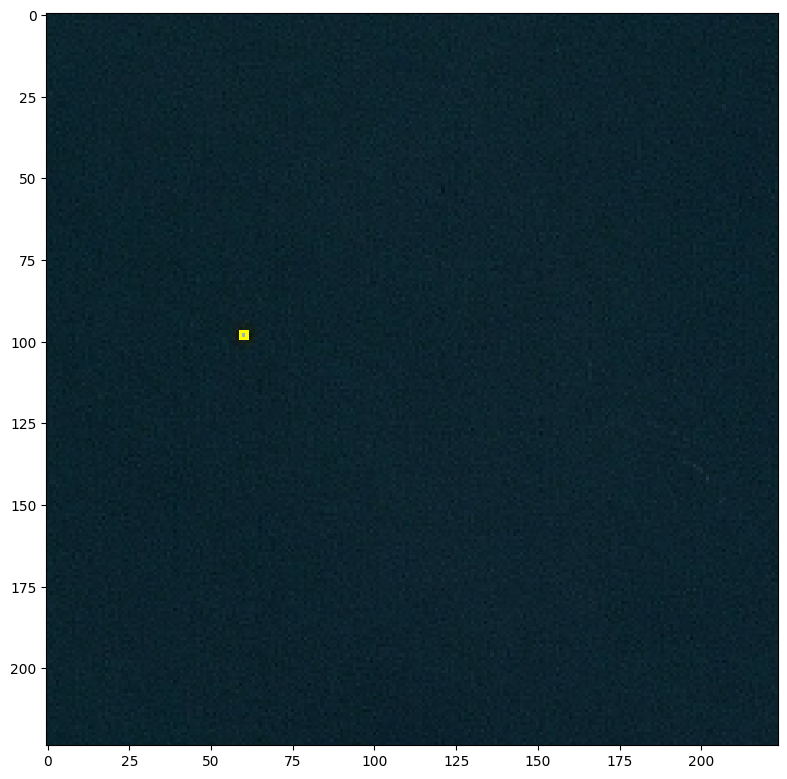

el_dict has 1 bboxes
el_dict has el_dict["boxes"] = tensor([[0.3411, 0.0495, 0.3867, 0.0924]])
image id d1f4649a8.jpg


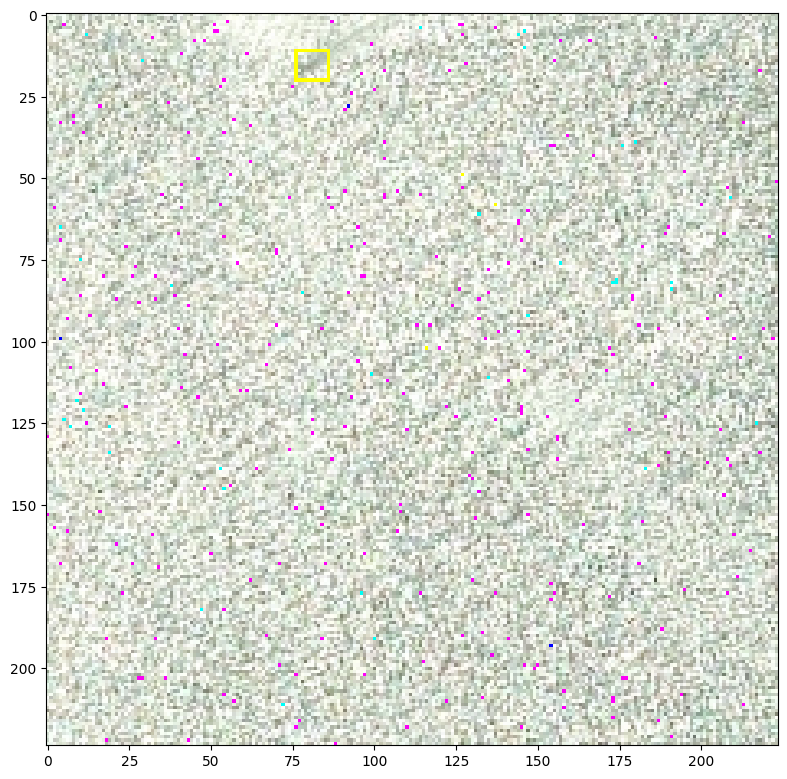

el_dict has 1 bboxes
el_dict has el_dict["boxes"] = tensor([[0.5573, 0.5299, 0.5951, 0.5599]])
image id 0c6caf8b9.jpg


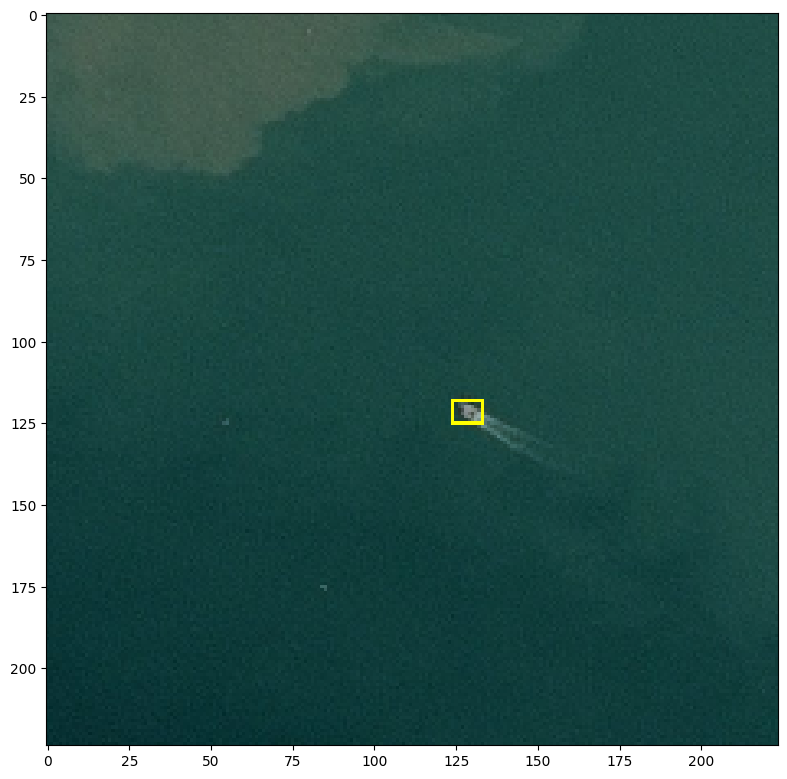

el_dict has 3 bboxes
el_dict has el_dict["boxes"] = tensor([[0.4596, 0.7643, 0.5026, 0.7995],
        [0.1536, 0.7396, 0.1966, 0.7773],
        [0.0273, 0.3880, 0.0794, 0.4310]])
image id de3484088.jpg


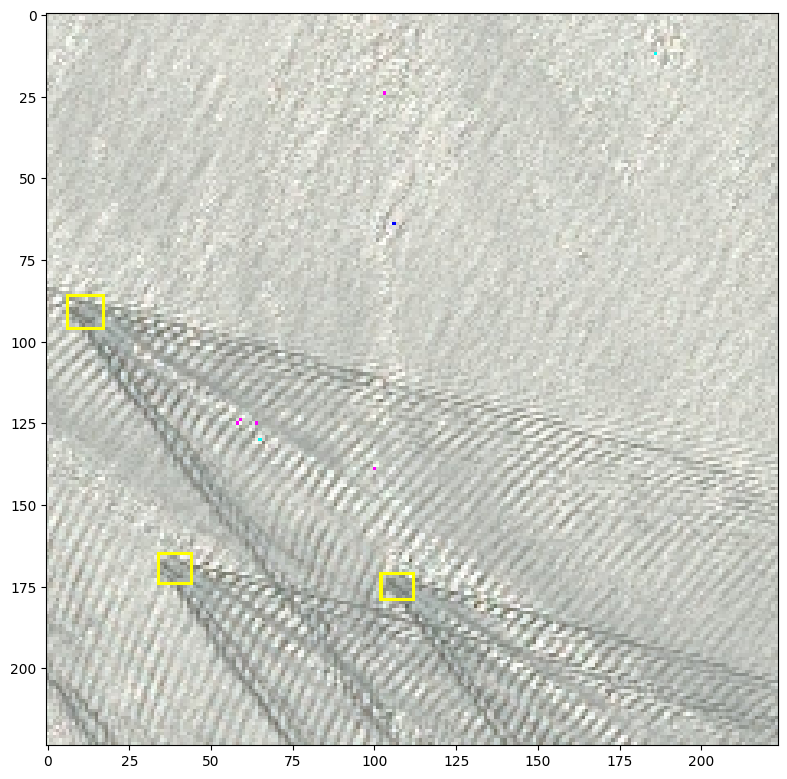

el_dict has 1 bboxes
el_dict has el_dict["boxes"] = tensor([[0.3398, 0.0000, 0.5117, 0.2917]])
image id 63c64dc37.jpg


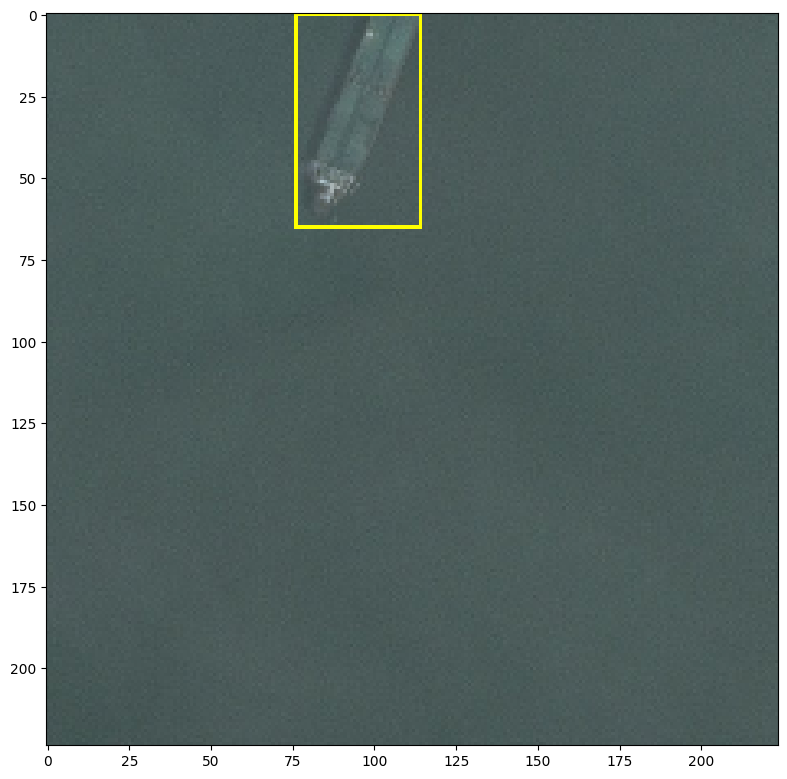

el_dict has 3 bboxes
el_dict has el_dict["boxes"] = tensor([[0.4440, 0.4180, 0.5521, 0.4948],
        [0.7422, 0.0859, 0.7760, 0.1042],
        [0.3529, 0.7487, 0.6875, 0.9336]])
image id 8217a547d.jpg


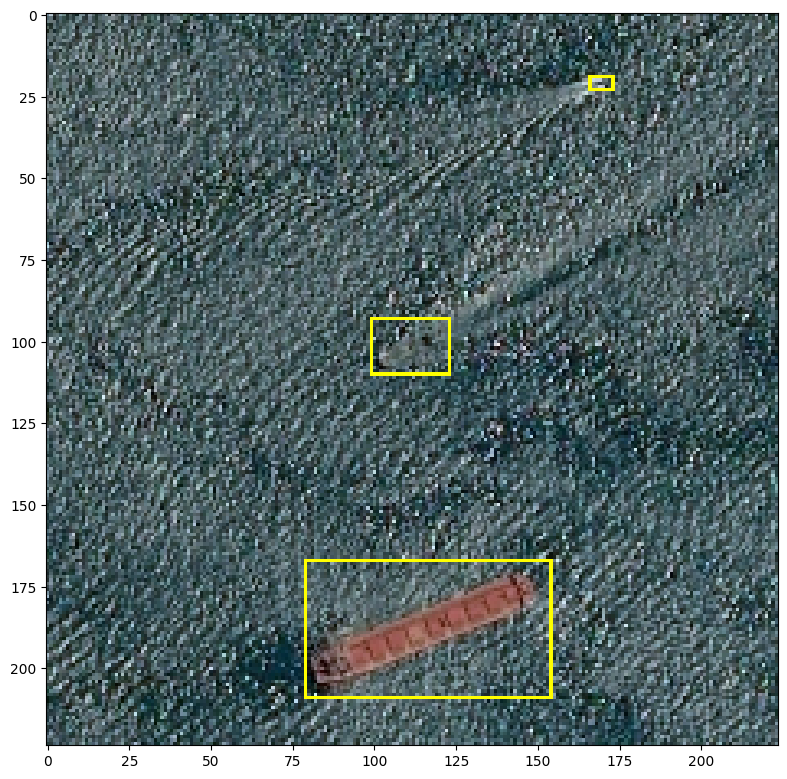

el_dict has 1 bboxes
el_dict has el_dict["boxes"] = tensor([[0.2214, 0.5755, 0.2435, 0.5990]])
image id 2b00176bb.jpg


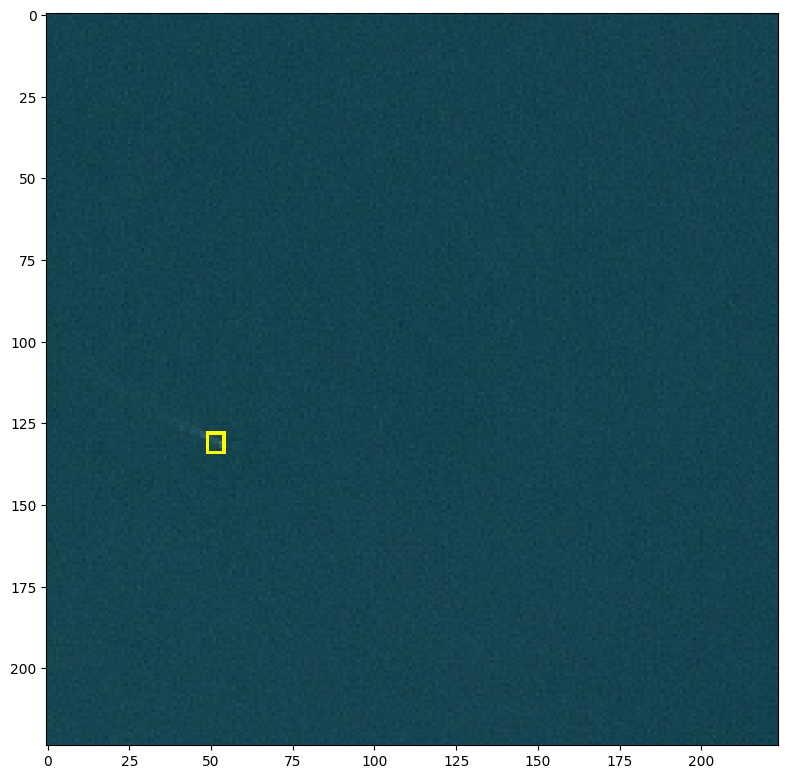

el_dict has 1 bboxes
el_dict has el_dict["boxes"] = tensor([[0.2448, 0.5286, 0.2617, 0.5495]])
image id ee6738a16.jpg


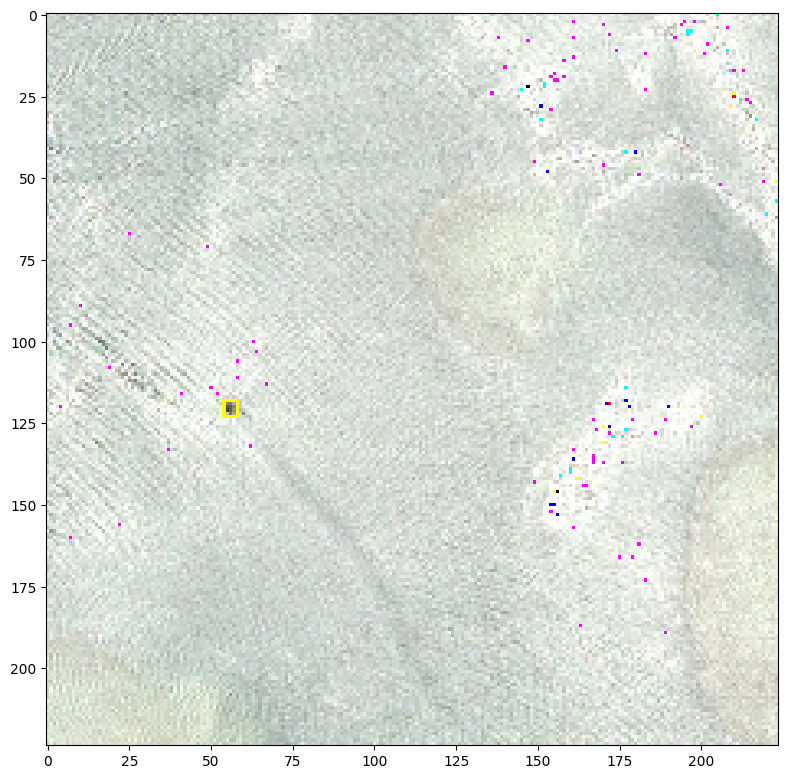

el_dict has 1 bboxes
el_dict has el_dict["boxes"] = tensor([[0.0143, 0.0000, 0.2565, 0.3086]])
image id 0f51d5360.jpg


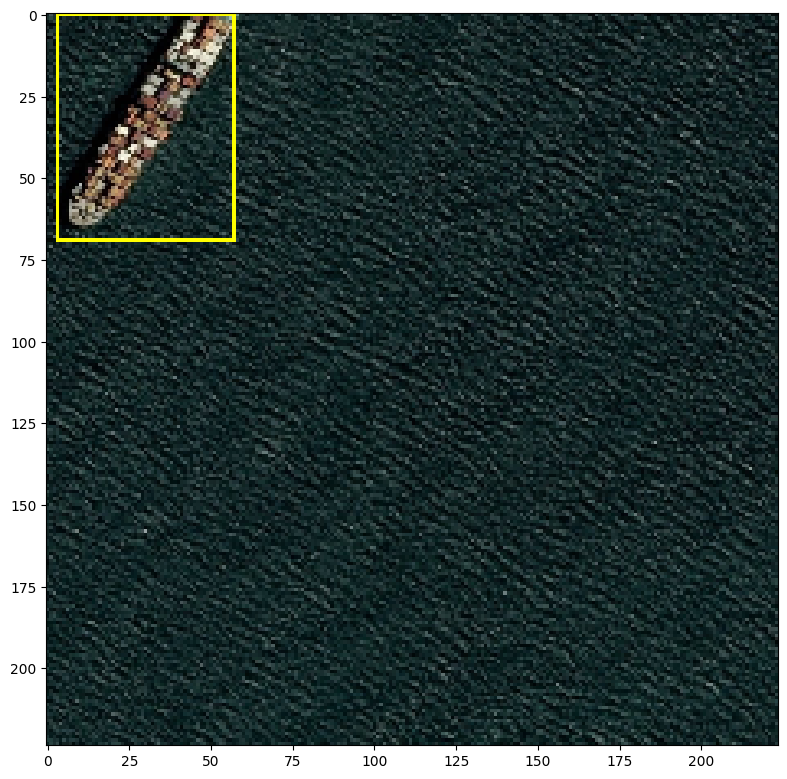

KeyboardInterrupt: 

In [29]:
#### START MODEL TRAINING

if not test_only:
    
    model = new_model()
    model.to(device)
    torch.compile(model)
    optimizer = optim.Adam(params = model.parameters(), lr = init_lr, weight_decay=0.01)

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma = 0.9,
        step_size = 5,
    )
    
    criterion = nn.CrossEntropyLoss()
    
    logger.info(f"Beginning training, {num_epochs = }, {device = }, {data_augmentation_type = }, {batch_size = }")
    print(f"Beginning training, {num_epochs = }, {data_augmentation_type = }, {batch_size = }")
    print(f"{device = }")
    
    train(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs=num_epochs, device=device)
    
    # plots
#     fig, ax = plt.subplots()
#     ax.plot(lrs)    
#     ax.set(xlabel='epoch', ylabel='learning rate value')
#     fig.savefig(os.path.join(model_filepath, "lrs.png"))
#     print(f"{lrs = }")
#     logger.info(f"{lrs = }")

In [ ]:
# Plot data

# if plot_data:
    
#     import matplotlib.pyplot as plt
    
#     pass

In [ ]:
# Per scaricare il contenuto di kaggle/working (e quindi recuperare i modelli)
# Crea lo zip della cartella che è stata creata contenente il modello e i log

# from IPython.display import FileLink
# !zip -r file.zip {model_filepath}
# FileLink(r'file.zip')

In [ ]:

from torchmetrics.detection import MeanAveragePrecision
import torchvision.transforms.functional as F

def test(model, test_loader, device=torch.device("cpu")): 
    
    model.transform.image_mean  = image_mean_test
    model.transform.image_std = image_std_test
    model._skip_resize = True
    
    model.eval()
    num_correct = 0
    num_examples = 0
    test_loss = 0
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.75])
    mAP = 0
    
    for i,batch in enumerate(test_loader):
        print("batch", i)
        
        inputs = []
        targets = []
        
        for el in batch:       # el = ((image,dict),dict)
            if el[1]['boxes'].size()[0] != 0:
                inputs.append(el[0].to(device))
                targets.append(el[1])
                
        if len(inputs) == 0:
            continue
        
        output = model(inputs)
        # print(type(model(torch.cuda.FloatTensor(inputs))))
#         print("out :\n", output)
#         print("target :\n",targets)
        #     # Example output
        #     {'boxes': tensor([[
        #       0.3801,  0.3060,  3.5638,  3.0348],
        #     [ 0.2037,  0.6570,  1.9538,  4.9389],
        #     [ 0.4993,  0.7045,  5.1531,  5.5368],
        #     [ 0.7172,  0.0860,  8.0819,  3.2724],
        #     [ 0.3548,  1.4842,  3.9183,  9.8673],
        #     [ 0.9226,  0.4096, 11.7943,  6.0310]], grad_fn=<StackBackward0>),
        #     labels': tensor([1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9762, 0.9498, 0.9188, 0.8941, 0.3722, 0.2909],
        #     grad_fn=<IndexBackward0>)},
        
        """
        scores come from RoIHeads class:
        pred_scores = F.softmax(class_logits, -1)
        after deleting empy boxes, low scored boxes and applying non-max suppression
        """
        for dic in output:
            dic["boxes"] = dic["boxes"].to(device)
            dic["labels"] = dic["labels"].to(device)
            dic["scores"] = dic["scores"].to(device)
            
        res = metric(output,targets)
        mAP += res['map_75']
        #print(res)

        
    mAP /= len(test_loader)  
    print( 'Mean Average Precision: {:.4f}'.format(mAP))

print("ok")

In [ ]:
# START MODEL TEST

if do_model_test or test_only:
#     checkpoint = torch.load(os.path.join('/kaggle/input/model-trained', "model.tar")) # LUDO
    checkpoint = torch.load(os.path.join(model_filepath, "model.tar"), map_location=device) # ENF
    test_loader = torch.load(os.path.join(model_filepath, "test_loader.pt"), map_location=device)
    
    model = new_model()
    model.load_state_dict(checkpoint['model_state_dict'])

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("model is now using cuda")

    test(model.to(device), test_loader, device)

# checkpoint = torch.load(os.path.join('/kaggle/input/model-trained', "model.tar")) # ludo
# #checkpoint = torch.load(os.path.join(model_filepath, "model.tar")) # enf
# model.load_state_dict(checkpoint['model_state_dict'])
# test(model.to(device), test_loader, device=device)


In [ ]:
# TRAIN AGAIN (Continue training)

import pickle

train_again = True

if train_again:    
    # Load loaders
    train_loader = torch.load(os.path.join(model_filepath, 'train_loader.pt'), map_location=device)
    val_loader = torch.load(os.path.join(model_filepath, 'val_loader.pt'), map_location=device)
    test_loader = torch.load(os.path.join(model_filepath, 'test_loader.pt'), map_location=device)
    print("Loadeders and model loaded succesfully") 
    
#     print(f"{device = }")
    
    model = new_model()
    
    # Load model from checkpoint
    checkpoint = torch.load(os.path.join(model_filepath, "model.tar"), map_location=device)
    
    criterion = nn.CrossEntropyLoss()
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    optimizer = optim.Adam(params = model.parameters(), weight_decay=0.01, lr = 1e-2)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma = 0.9,
        step_size = 5,
    )
    
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    training_losses = checkpoint['training_losses']
    validation_losses = checkpoint['validation_losses']
    lrs = checkpoint['lrs']
    epoch = checkpoint['epoch']
    # Resume training from a specific epoch
    # optimizer = optim.Adam(params = model.parameters(), lr=0.01)
    
    # Il file salvato model.tar contiene optiimzer, scheduler, loss e tanto altro

    logger.info(f"Continuing training, {num_epochs = }, {device = }, {data_augmentation_type = }, {batch_size = }")
    train(model, optimizer, scheduler, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=num_epochs, device=device)





simo e' intelligente

simo e' intelligente, 

simo e' buono, ludo e' bella,
enf e' attraente, simo e' buonosimo e' intelligente, 
ludo e' intelligente

simo e' intelligente
ludo e' buona

enf e' attraente

ludo e' buona, 










































